## Predict the skipping behavior of the validation dataset

In [1]:
import pandas as pd
import numpy as np
import tarfile
import io
import glob
import dask.dataframe as dd


import lightgbm as lgb
import warnings
warnings.simplefilter("ignore")

import myFunc as mf



tar = tarfile.open('../data/raw/20181120_track_features.tar.gz', 'r:gz')
csv_files = tar.getnames()

tf_df_list = []

for csv_file in [csv_files[2], csv_files[4]]:
    csv_contents = tar.extractfile(csv_file).read()
    tf_df_list.append(pd.read_csv(io.BytesIO(csv_contents), encoding='utf8'))

tf_df = pd.concat(tf_df_list, ignore_index=True)
tf_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)

kmean300_df = pd.read_csv('../data/interim/all_data/mbKMeans300clusters.csv', usecols=['track_id','clus'])
kmean300_df.rename(columns={'track_id':'track_id_clean'}, inplace=True)



In [2]:
# validation data
file_list = ['../data/raw/training_set/log_0_20180918_000000000000.csv']

In [3]:
# the same data processing steps but without weights and track selection

def prep_dfs_eval(file, tf_df, simFolder, kmean_df):
    log_df = pd.read_csv(file)
    log_df = log_df.merge(kmean_df)

    log_df_1 = log_df.loc[log_df['session_position']<=(log_df['session_length']/2)]
    log_df_1['hour_of_day'] = log_df_1['hour_of_day'].astype('float')
    log_df_1['premium'] = log_df_1['premium'].astype('bool')
    log_df_1 = log_df_1.drop(columns = ['date'])
    log_df_1 = pd.get_dummies(log_df_1, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type'], dtype = 'bool')
    log_df_1 = log_df_1.merge(tf_df.drop(columns = ['time_signature','mode','key']))
    
                     
    col_bool = log_df_1.columns[log_df_1.dtypes=='bool']
    col_nonbool = log_df_1.columns[log_df_1.dtypes!='bool'].drop(['session_id','track_id_clean','clus'])
    
    # the non-convertable values will be set to 0
    log_df_1[col_nonbool] = log_df_1[col_nonbool].apply(pd.to_numeric, errors='coerce', downcast = 'float').fillna(0).astype('float32')

    # aggregate the track history where ['skip_2']==True
    log_df_1_summary_skip2True = pd.concat([log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_bool].agg(['mean']), 
                                            log_df_1.loc[log_df_1['skip_2']==True].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                            axis = 1)
    log_df_1_summary_skip2True.columns = log_df_1_summary_skip2True.columns.get_level_values(0)+'_sk2True_'+log_df_1_summary_skip2True.columns.get_level_values(1)
    
    # aggregate the track history where ['skip_2']==False
    log_df_1_summary_skip2False = pd.concat([log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_bool].agg(['mean']), 
                                             log_df_1.loc[log_df_1['skip_2']==False].groupby(['session_id'])[col_nonbool].agg(['mean', 'std', 'median'])],
                                             axis = 1)
    log_df_1_summary_skip2False.columns = log_df_1_summary_skip2False.columns.get_level_values(0)+'_sk2False_'+log_df_1_summary_skip2False.columns.get_level_values(1)
    
    
    log_df_history = log_df_1[['session_id','track_id_clean','skip_2','clus']]


    half_cut = log_df['session_length']/2


    log_df_2 = log_df.loc[(log_df['session_position']>half_cut)]
    log_df_2 = log_df_2[['session_id','track_id_clean','skip_2','session_position','session_length','clus']]
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2True, on='session_id')
    log_df_2 = log_df_2.merge(log_df_1_summary_skip2False, on='session_id')
    

    sim_file_list = ['../models/SVD/all_tracks/'+simFolder+'/k300_CanbDist.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_CosSim.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_LinCorr.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_ManhDist.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_HammDist.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_SpearCorr.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_KendCorr.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_ChebDist.csv',
                     '../models/SVD/all_tracks/'+simFolder+'/k300_BrayDist.csv']
    score_name_list = ['CanbDist300', 'CosSim300','LinCorr300','ManhDist300','HammDist300','SpearCorr300','KendCorr300','ChebDist','BrayDist']

    return mf.get_sim(log_df_history, log_df_2, sim_file_list, score_name_list)

In [5]:
# predict the skipping behavior based on the fitted model

from timeit import default_timer as timer #to see how long the computation will take

df_lookup_list = []
for file in file_list[0:1]:
    start = timer()
    df_lookup_list.append(prep_dfs_eval(file, tf_df, 'similarity_20180917-20180917', kmean300_df))
    
df_lookup = pd.concat(df_lookup_list)
df_lookup = df_lookup.merge(tf_df.drop(columns = ['key','time_signature','mode']))

# check whether the column names match with the previous training set
prev_feature_names = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec17/for20180918/boost_alltracks_incrementalTrain_10_dec23.txt').feature_name()
if bool(set(prev_feature_names) - set(df_lookup.columns)): # if there are missing columns
            df_lookup[list(set(prev_feature_names) - set(df_lookup.columns))] = 0 # add the missed columns with 0

if bool(set(df_lookup.columns)- set(prev_feature_names)): # if there are extra columns
    extra_cols = list(set(df_lookup.columns)- set(prev_feature_names) - set(['session_id','track_id_clean','skip_2','weight']))
    df_lookup.drop(columns = extra_cols, inplace = True)

df_lookup.sort_values(['session_id','session_position'], inplace = True)
df_test = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).astype('float32')
X = df_lookup.drop(columns = ['session_id','track_id_clean','skip_2']).to_numpy()

bst = lgb.Booster(model_file='../models/SVD/LightGBM_BayesOpt_dec17/for20180918/boost_alltracks_incrementalTrain_10_dec23.txt')  # init model

ypred = bst.predict(df_test)
print('Runtime per batch: %0.2fs' % (timer() - start))

Runtime per batch: 91.92s


In [6]:
df_lookup

,session_id,track_id_clean,skip_2,session_position,session_length,clus,skip_1_sk2True_mean,skip_2_sk2True_mean,skip_3_sk2True_mean,not_skipped_sk2True_mean,...,tempo,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
463004,65_0000b60c-d39c-4554-8371-354729ed60c0,t_51956520-ce7a-4604-9bcb-56bfff7b2736,False,11,20,282,0.714286,1.0,1.0,0.0,...,142.056000,0.556551,-0.448360,0.266142,0.200711,-0.102771,-0.552026,0.167256,-0.056987,0.605874
463045,65_0000b60c-d39c-4554-8371-354729ed60c0,t_25d11783-1ca4-427a-95e6-4f557b2b83c9,True,12,20,251,0.714286,1.0,1.0,0.0,...,142.029007,0.254356,-0.309036,0.217209,0.225878,-0.143391,-0.540390,0.220587,0.037699,0.617515
464069,65_0000b60c-d39c-4554-8371-354729ed60c0,t_ba244873-8564-4ea6-b8bc-d0793b0d0dff,True,13,20,66,0.714286,1.0,1.0,0.0,...,142.014999,0.173213,-0.350981,0.286125,0.236305,-0.114115,-0.523562,0.217533,0.099462,0.628256
464215,65_0000b60c-d39c-4554-8371-354729ed60c0,t_df63af76-311f-4d85-877f-69b356cb5054,True,14,20,172,0.714286,1.0,1.0,0.0,...,142.065002,0.192292,-0.346976,0.306263,0.263410,-0.157135,-0.554300,0.240247,0.083986,0.636656
464234,65_0000b60c-d39c-4554-8371-354729ed60c0,t_8849e9af-6413-4661-9628-f3f503a64f62,True,15,20,109,0.714286,1.0,1.0,0.0,...,140.037994,0.099212,-0.313165,0.229884,0.208512,-0.152276,-0.645428,0.243758,0.069302,0.795294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084986,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_6a18d618-a863-4710-a0f7-edc959e65ad5,False,16,20,69,0.625000,1.0,1.0,0.0,...,165.897003,0.268866,0.063448,0.452877,-0.178410,-0.603517,0.177323,0.126411,-0.378101,0.060804
1137804,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_26e4c895-8d92-4cf7-b6c9-d41861c43f27,False,17,20,287,0.625000,1.0,1.0,0.0,...,179.990005,0.347908,0.169253,0.614182,-0.390072,-0.725376,0.397905,0.171512,-0.376916,0.395052
889714,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_38157f38-9cc5-4248-ac96-60b571e8b37b,False,18,20,188,0.625000,1.0,1.0,0.0,...,134.014008,0.718833,0.077334,0.471669,-0.277773,-0.722327,0.294819,0.186959,-0.470139,0.162687
1081226,65_ffffbf79-3810-48ca-a97e-788a5e87851d,t_07074f30-ad55-42f5-a608-e72fd80013b0,False,19,20,129,0.625000,1.0,1.0,0.0,...,135.860992,0.389706,0.183129,0.135919,-0.423383,-0.510713,0.689540,0.149603,-0.344343,0.013874


In [7]:
ytrue = df_lookup['skip_2']
ytrue

463004     False
463045      True
464069      True
464215      True
464234      True
           ...  
1084986    False
1137804    False
889714     False
1081226    False
889711     False
Name: skip_2, Length: 1363022, dtype: bool

In [8]:
ypred

array([0.74003304, 0.68495241, 0.66936033, ..., 0.46534724, 0.41367486,
       0.42543361])

As it is too slow to calculate the AP of all the sessions in a file. I picked the first 10000 tracks as the validation dataset.

In [9]:
s_list = df_lookup['session_id'].unique()[0:10000]
sel_row = df_lookup['session_id'].isin(s_list)

In [10]:
ap,first_pred_acc  = mf.spotify_eval(ytrue[sel_row], ypred[sel_row]>0.5, df_lookup.loc[sel_row])

In [11]:
ap

0.5706305176051972

In [12]:
first_pred_acc

0.7439

A sanity check whether 0.5 is the best threshold (although this information cannot be obtain a priori)

In [13]:
from sklearn.metrics import accuracy_score
acc = []
for x in np.arange(0,1,0.01):
    acc.append(accuracy_score(ypred>x, ytrue*1))

max(acc)

0.6767506320514269

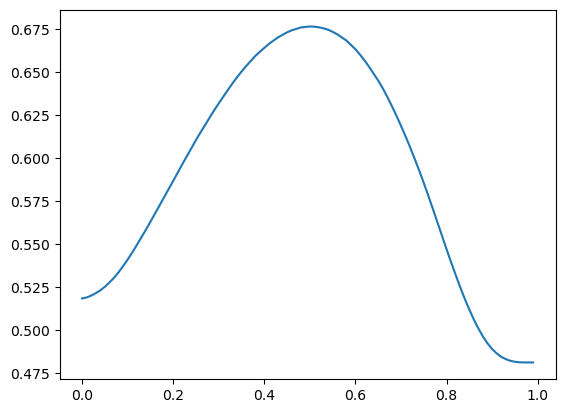

0.5

In [14]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,1,0.01), acc)
plt.show()
max_index = acc.index(max(acc))
max_index/100

Yes, 0.5 is the best threshold.

# Visualizing the influence of each feature by SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model.

https://shap.readthedocs.io/en/latest/

In [ ]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
bst.params['objective'] = 'binary'
bst.params

In [ ]:
explainer = shap.TreeExplainer(bst)

In [ ]:
start = timer()
shap_values = explainer.shap_values(df_test)
print('Runtime per batch: %0.2fs' % (timer() - start))

In [ ]:
shap.summary_plot(shap_values[0], df_test, max_display = 40, plot_size = (15,10), show=False)
plt.savefig('../reports/figures/SHAPsummary0_boost_alltracks_incrementalTrain_10_dec23.png')
plt.show()

In [ ]:
shap.summary_plot(shap_values[1], df_test, max_display = 40, plot_size = (15,10), show=False)
plt.savefig('../reports/figures/SHAPsummary1_boost_alltracks_incrementalTrain_10_dec23.png')
plt.show()

How to interpret this plot? Take the "SHAPsummary1" for instance, the "SpearCorr300" feature in the plot means that, the observations with lower values of SpearCorr300 (more blue) are more likely to be predict it as "skip2==True" (higher SHAP value). It makes sense as lower SpearCorr300 means the current track is less similar with the preferred tracks in the 1st half of the same session. For the "SHAPsummary0" plot, it is the opposite (skip2==False). See my report for more in-depth interpretations.

In [ ]:
# shap.dependence_plot(ind = 'session_position', shap_values=shap_values[0], features=df_test, show=False)
# plt.savefig("my_dependence_plot.pdf")
# plt.show()

In [ ]:
# shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], df_test.iloc[:1000,:])